In [46]:
#코랩 실행시 주석해체
# !pip install tokenizers
# !pip install transformers
# !pip install konlpy
# !pip install soynlp

모델_2  
메켑미적용 => 워드피스토큰화 => (커스텀레이어 추가된)가벼운 BERT모델 적용

==마디별 워드피스 토큰화==

In [47]:
import tensorflow as tf
import numpy as np
import pandas as pd
import re
from soynlp.normalizer import repeat_normalize
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from collections import Counter

#필요없는 경고무시
import warnings
warnings.filterwarnings('ignore')

#시각화용 임포트 모음
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go

In [48]:
#한국어 감성사전 불러온다.
with open('../SentiWord_Dict.txt', 'r', encoding='utf-8') as f:
    SentiWord_Dict = f.read()


#데이터 프레임 생성
df_train = pd.DataFrame({
    'Sentiword': [line.split('\t')[0] for line in SentiWord_Dict.split('\n') if len(line.split('\t')) >= 2],
    'Point': [int(line.split('\t')[1]) for line in SentiWord_Dict.split('\n') if len(line.split('\t')) >= 2]
})


#널값있는지 확인
empty_string_exists = any(list(map(lambda x, y: x == "" or y == "", df_train['Sentiword'], df_train['Point'])))

if empty_string_exists:
    print("널값이 존재합니다.")
    df_train[{'Sentiword','Point'}].replace('', np.nan, inplace=True)
    df_train.dropna( inplace=True)
    print("널값 제거하였습니다.")
else:
    print("널값이 없습니다.")


널값이 없습니다.


In [49]:
df_train

,Sentiword,Point
0,(-;,1
1,(;_;),-1
2,(^^),1
3,(^-^),1
4,(^^*,1
...,...,...
14851,내팽개치다,-2
14852,횡령,-2
14853,불안증,-2
14854,어쩔티비,-1


리뷰의 최대 길이 : 31
리뷰의 평균 길이 : 5.623653742595584


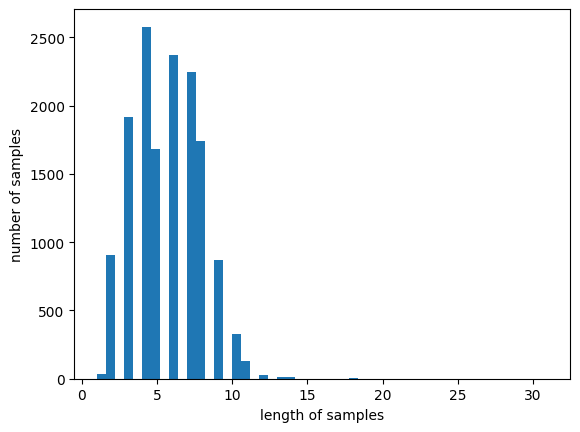

In [50]:
# 감성 단어 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in df_train['Sentiword']))
print('리뷰의 평균 길이 :',sum(map(len, df_train['Sentiword']))/len(df_train['Sentiword']))
plt.hist([len(review) for review in df_train['Sentiword']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

max_length = max(len(review) for review in df_train['Sentiword'])

word piece시작

In [51]:
# WordPiece 토큰화를 위한 사전 훈련된 모델 불러오기
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [52]:
#전처리 함수정의
#리스트형태로 모델에 들어간다
train_encodings = tokenizer(df_train['Sentiword'].tolist(), truncation=True, padding=True, max_length=max_length) 


In [93]:
#수치형 데이터
print(train_encodings['input_ids'][10035])
#토큰화된 텍스트
print(tokenizer.convert_ids_to_tokens(train_encodings['input_ids'][10035]))
#원본텍스트
print(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(train_encodings['input_ids'][10035])))

[101, 9608, 60479, 30873, 61945, 9083, 11287, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['[CLS]', '움', '##츠', '##러', '##드는', '데', '##가', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[CLS] 움츠러드는 데가 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [55]:
train_encodings.keys()
max_length = len(train_encodings.input_ids[0])

In [67]:
# 입력 데이터로 변환
train_input_ids = np.array(train_encodings['input_ids'])
train_attention_mask = np.array(train_encodings['attention_mask'])
train_token_type_ids = np.array(train_encodings['token_type_ids'])

train_labels = np.array(df_train['Point'].apply(lambda x: x+2).tolist())


In [80]:
from transformers import DistilBertConfig, TFDistilBertForSequenceClassification
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# BERT 모델 불러오기
config = DistilBertConfig.from_pretrained(
    "distilbert-base-multilingual-cased",
    num_labels=5,
    hidden_dropout_prob=0.3,
)
bert_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-multilingual-cased",config=config)


Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier', 'dropout_237', 'pre_classifier']
You should probably TRAIN this model on a down-stream t

In [83]:

# 입력 정의 
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")


# BERT 출력 얻기
bert_output = bert_model(input_ids, attention_mask=attention_mask)
sequence_output = bert_output[0]

# 커스텀 레이어 정의
x = Dense(64, activation='relu')(sequence_output)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
output = Dense(5, activation='softmax')(x)

# 모델 생성
custom_bert_model = Model(inputs=[input_ids, attention_mask], outputs=output)



In [84]:
custom_bert_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 23)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 23)]         0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  135328517  ['input_ids[0][0]',              
 assification_11 (TFDistilBertF  rOutput(loss=None,               'attention_mask[0][0]']         
 orSequenceClassification)      logits=(None, 5),                                                 
                                 hidden_states=None                                         

In [95]:
# 컴파일
custom_bert_model.compile(
    optimizer=Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

early_stop=tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=5,
    restore_best_weights=True
)

# 모델 학습
custom_bert_model.fit(
    [train_input_ids, train_attention_mask],
    train_labels,
    batch_size=32, epochs=10, validation_split=0.25, 
    callbacks=[early_stop]
)

Epoch 1/10
 20/349 [>.............................] - ETA: 22:27 - loss: 1.4800 - accuracy: 0.3703

KeyboardInterrupt: 

In [60]:
from transformers import TextClassificationPipeline
# 예측용 파이프라인 생성
pipeline = TextClassificationPipeline(model=custom_bert_model, tokenizer=tokenizer, framework="tf")



AttributeError: ignored

In [56]:
# 예측 예시
example_texts = ['회식끝나고 집가는중','개꿀잼이네','진짜 너무 별로다.','ㅋㅋㅋㅋㅋㅋㅋㅋ재밌따','나는 잘봤다.']
#정제
clean_test_texts=[]
for i in example_texts:
    clean_test_texts.append(clean_korean_text(i))


clean_test_texts

['회식끝나고 집가는중', '개꿀잼이네', '진짜 너무 별로다', 'ㅋ재밌따', '나는 잘봤다']

In [58]:
#정제된 텍스트를 벡터화하기전에 토큰화한다
from konlpy.tag import Okt
mecab=Okt()

clean_test_texts1 = [ mecab.morphs(i) for i in clean_test_texts]
print(clean_test_texts1)

clean_test_texts2=[]
for i in clean_test_texts1:
    clean_test_texts2.append(' '.join(i))
print(clean_test_texts2)

[['회식', '끝나고', '집가는', '중'], ['개꿀잼', '이네'], ['진짜', '너무', '별로', '다'], ['ㅋ', '재밌', '따'], ['나', '는', '잘', '봤다']]
['회식 끝나고 집가는 중', '개꿀잼 이네', '진짜 너무 별로 다', 'ㅋ 재밌 따', '나 는 잘 봤다']


In [59]:
predicted = pipeline(clean_test_texts2)
print("Prediction:", predicted)

NameError: ignored

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
#테스트문장 입력
test = ['회식끝나고 집가는중','개꿀잼이네','진짜 너무 별로다.','ㅋㅋㅋㅋㅋㅋㅋㅋ재밌따']

#정제
clean_test_texts=[]
for i in test:
    clean_test_texts.append(clean_korean_text(i))

max_length = 64
# 텍스트 데이터 토큰화
tokenized_test_texts = [tokenizer.encode(text, max_length=max_length, pad_to_max_length=True) for text in clean_test_texts]
tokenized_test_texts

# 토큰화된 텍스트를 Numpy 배열로 변환
tokenized_test_texts = np.array(tokenized_test_texts)
tokenized_test_texts

#벡터화
x_test = pad_sequences(tokenized_test_texts,padding='post',maxlen=max_length) 

#예측
prediction = model.predict(x_test)  

for i in np.round(prediction):
    print(int(i))

1/1 [==============================] - 1s 561ms/step
0
1
0
1


# 서비스 테스트

In [ ]:
#모델 불러오기
from tensorflow.keras.models import load_model
loaded_model= load_model('./wordpiece_test.h5')

# #저장된 vectorizer 불러오기
# import pickle
# with open('./lstm_tokenizer.pkl', 'rb') as f:
#     loaded_test_vectorizer = pickle.load(f)

In [ ]:
# 카톡대화 불러와서 정제,(정규화코드)하는 함수
import re

def get_from_txt(txt):
    data= open(txt,"r", encoding='utf-8').read().split('\n')
    sentences=[]
    for line in data:
        pattern = r'\[(.*?)\]\s+\[(.*?)\]\s+(.+)'
        match = re.match(pattern, line)
        if match:
            name = match.group(1)  # 첫 번째 대괄호 안의 단어 추출
            time = match.group(2)  # 두 번째 대괄호 안의 단어 추출
            content = match.group(3)  # 대괄호 뒤의 내용 추출
            # print(name, time, content)
            temp=[name,time,content]
            sentences.append(temp)    
    return sentences

#함수확인
get_from_txt('sample.txt')

[['김찬란', '오후 10:01', '사진'],
 ['김찬란', '오후 9:38', 'https://youtube.com/watch?v=o1G7DWFFHso&feature=share'],
 ['김찬란', '오후 10:42', '사진'],
 ['김찬란', '오후 10:42', '사기치고다니는 한장규'],
 ['김하영', '오후 10:45', '이야'],
 ['김하영', '오후 10:46', '게임에서도 치네'],
 ['김찬란', '오후 10:46', '진짜 니말이 맞다 진짜 친구면 친구한테 민폐되기 싫어서 돈빌려달란 소리도 안한다'],
 ['김하영', '오전 12:25', '이모티콘'],
 ['김하영', '오전 12:35', '회식끝나고 집가는중'],
 ['김찬란', '오전 12:35', '음음 초밥집 회식은 어디서 하냐'],
 ['김하영', '오전 12:35', '우리 실장형네 직이 고기집해서 글로갔다'],
 ['김하영', '오전 12:36', '회식하면 맨날 돼지고기만 먹는다'],
 ['김찬란', '오전 12:36', 'ㅋㅋㅋㅋㅋㅋ케'],
 ['김하영', '오전 12:36', '이모티콘'],
 ['김찬란', '오전 12:36', '아 내수용 회식'],
 ['김찬란', '오전 12:36', '사진'],
 ['김하영', '오전 12:36', 'ㅋㅋㅋㅋ 그런거 아니고 애들이 여기가 맛있다고 여기서먹음'],
 ['김찬란', '오전 12:37', '고기 얘시하니까'],
 ['김찬란', '오전 12:37', '나도 고기가 먹고 싶군'],
 ['김하영', '오전 12:37', 'ㅋㅋㅋㅋ '],
 ['김찬란', '오전 12:37', '낼 사먹어야겠다'],
 ['김하영', '오전 12:37', '와라 엉아가 소고기 사줄께'],
 ['김찬란', '오전 12:37', '내가 사야지 씹새야 입벌려'],
 ['김찬란', '오전 12:37', '고기 들어간'],
 ['김찬란', '오전 12:38', '너는 내가 사주고 싶으니까 '],
 ['김찬란', '오전 12:38', '취직해서

In [ ]:
#닉네임 입력단 
# target_name = str(input())
target_name = '김하영'
print(target_name)  #김하영 입력

김하영


In [ ]:
# 저장된 모델 불러오기
# from tensorflow.keras.models import load_models
# model= load_models('4_6_DNN 토큰화수정.h5')


#입력된 이름의 '대화내역만' 담기
received_texts= []
for i in get_from_txt('sample.txt'): 
    if i[0] == target_name:
        received_texts.append( i[2] )
        
# 이모티콘, 사진, 샵검색 제거 
clean_received_texts2 = []
for i in received_texts:
    if '샵검색:' not in i: 
        if "이모티콘" not in i:
            if '사진' not in i:
                clean_received_texts2.append(str(i))

#=========== 이쯤에서 답장시간 계산기 구현   =======================
          
          
#텍스트 정제  
clean_received_texts2= [clean_korean_text(i) for i in clean_received_texts2]
clean_received_texts2

# 텍스트 데이터 토큰화
tokenized_test_texts = [tokenizer.encode(text, max_length=max_length, pad_to_max_length=True) for text in clean_received_texts2]
tokenized_test_texts

# 토큰화된 텍스트를 Numpy 배열로 변환
tokenized_test_texts = np.array(tokenized_test_texts)
tokenized_test_texts

# 벡터데이터 변환
x_test = pad_sequences(tokenized_test_texts,padding='post',maxlen=64) 

# 모델을 사용하여 예측 수행
predictions = loaded_model.predict(x_test)
#예측 결과 출력 (긍정: 1, 부정: 0)
print(predictions.squeeze().tolist()) #차원을 축소하고 리스트객체로 변환

cnt0=0;cnt1=0; cnt2=0
for i in predictions.squeeze().tolist():
    if i <= 0.45:
        cnt0+=1
    elif i >= 0.55:
        cnt1+=1
    else :
        cnt2+=1
        
#부정과 긍정문의 갯수
print('부정문과 긍정문의 갯수:',cnt0,cnt1)
print('중립문장의 갯수:',cnt2)

#긍정과 부정의 비율( 긍정문의 수 / 부정문의 수)
print('긍정과 부정의 비율: ',cnt1/cnt0)
#숫자가 1이상이고 높을수록 긍정적이다.

6/6 [==============================] - 0s 7ms/step
[0.42015233635902405, 0.15778325498104095, 0.4034382998943329, 0.15830516815185547, 0.2756638824939728, 0.23274767398834229, 0.5671480298042297, 0.25340867042541504, 0.4362293481826782, 0.4002711772918701, 0.6111466884613037, 0.06004936248064041, 0.1837492287158966, 0.1312265843153, 0.2406095564365387, 0.08809877932071686, 0.3380661606788635, 0.17884549498558044, 0.544122040271759, 0.5671480298042297, 0.3253222107887268, 0.34540876746177673, 0.34540876746177673, 0.4286506474018097, 0.5671480298042297, 0.28317803144454956, 0.5671480298042297, 0.11938949674367905, 0.4006653428077698, 0.19541098177433014, 0.12212876230478287, 0.31381163001060486, 0.3801400661468506, 0.3815697431564331, 0.5671480298042297, 0.4159267246723175, 0.4814023971557617, 0.3980425298213959, 0.24305537343025208, 0.3207646906375885, 0.12008189409971237, 0.32288381457328796, 0.5671480298042297, 0.5671480298042297, 0.42395874857902527, 0.4516054093837738, 0.19916307926

In [ ]:
clean_received_texts2